In [1]:
from time import time
from os import listdir
from os.path import isdir, isfile
import glob
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update({'font.size': 15})
dirlist = np.array([d for d in listdir('results') if isdir(f'results/{d}') and (d != '.ipynb_checkpoints')])
sort_dirlist = []
for idx in np.arange(len(dirlist)) + 1:
    d = dirlist[ np.where(dirlist == f'1PGB-S{idx}_T0.0032_k10000.0')[0] ][0]
    sort_dirlist.append(d)

In [3]:
sort_dirlist

['1PGB-S1_T0.0032_k10000.0',
 '1PGB-S2_T0.0032_k10000.0',
 '1PGB-S3_T0.0032_k10000.0']

In [4]:
## Load simulation data
def load_data(d):
    datafiles = np.array([f for f in listdir(d) if isfile(f'{d}/{f}') and 'data' in f])
    file = datafiles[[not 'eq' in datafile for datafile in datafiles]][0]
    with open(f'{d}/{file}', 'r') as f:
        lines = f.readlines()
    splitted_lines = [line.split('\t') for line in lines]
    data = np.array(splitted_lines).astype(float)
    return data


## Load simulation mutations
def load_muts(d, return_pars = False):
    mutsfiles = np.array([f for f in listdir(d) if isfile(f'{d}/{f}') and 'mutants' in f])

    file = mutsfiles[[not 'eq' in mutsfile for mutsfile in mutsfiles]][0]
    with open(f'{d}/{file}', 'r') as f:
        lines = f.readlines()
    splitted_lines = [line.split('\t') for line in lines]
    muts = np.array(splitted_lines).astype(str)
    for idx in range(len(muts)):
        muts[idx, 1] = muts[idx, 1][:-1]

    if return_pars:
        splitted_d = d.split('/')
        seed = int(splitted_d[-1][1:])
        
        resplitted_d = splitted_d[-2].split('_')
        T = float(resplitted_d[-2][1:])
        k = float(resplitted_d[-1][1:])

    if return_pars:
        return muts, (T, k, seed)
    else:
        return muts

In [5]:
dirlist = sort_dirlist
k_target = 10_000

site_weights = np.load('../LocalEntropy/RestrainedMetropolis/run/inputs/site_weights.npy')
mask = site_weights == 1.
neutral_mask = np.ones(len(mask), dtype = bool)
onlyK_mask = np.ones(mask.astype(int).sum())

In [6]:
def calculate_Hamming_distances(sequences, ref_sequence, mask):
    sequences = np.array([list(sequence) for sequence in sequences])
    ref_sequence = np.array(list(ref_sequence))
    
    if np.all(mask):
        distances = np.array([len(np.where(sequence != ref_sequence)[0]) for sequence in sequences])
    else:
        weight = len(mask) - mask.astype(int).sum()
        tupled_sequences = np.array([(sequence[mask], sequence[~mask]) for sequence in sequences], dtype = object)
        tupled_ref_sequence = (ref_sequence[mask], ref_sequence[~mask])
        distances = np.array([
            len(np.where(tupled_sequence[0] != tupled_ref_sequence[0])[0]) + len(np.where(tupled_sequence[1] != tupled_ref_sequence[1])[0])/weight
            for tupled_sequence in tupled_sequences])
    
    return distances

In [7]:
colors = [
    'royalblue',
    'darkorange',
    'forestgreen'
]
shown_gens = 50_000
mean, std = 0.073677, 0.016134

xticks = np.arange(6) * 10_000
xticklabels = [r'0', r'1$\cdot$10$^{4}$', r'2$\cdot$10$^{4}$', r'3$\cdot$10$^{4}$', r'4$\cdot$10$^{4}$', r'5$\cdot$10$^{4}$']

S1: PTYRMEVMSTHFEAVVGIEAPNYPAALHGFVLFCHCLGVLAQFTYCATHNFFKVWQ
S2: HWYRFVHHGPNHECMGVARVPHVHWLMNAVEKATKAANIKCKYRWSARHRTLWCYT
S3: HEYSCMLISPLRTATQVFEATNRAMAHWFFEDMALWLGYIKKWTYNERFHMYTVTF


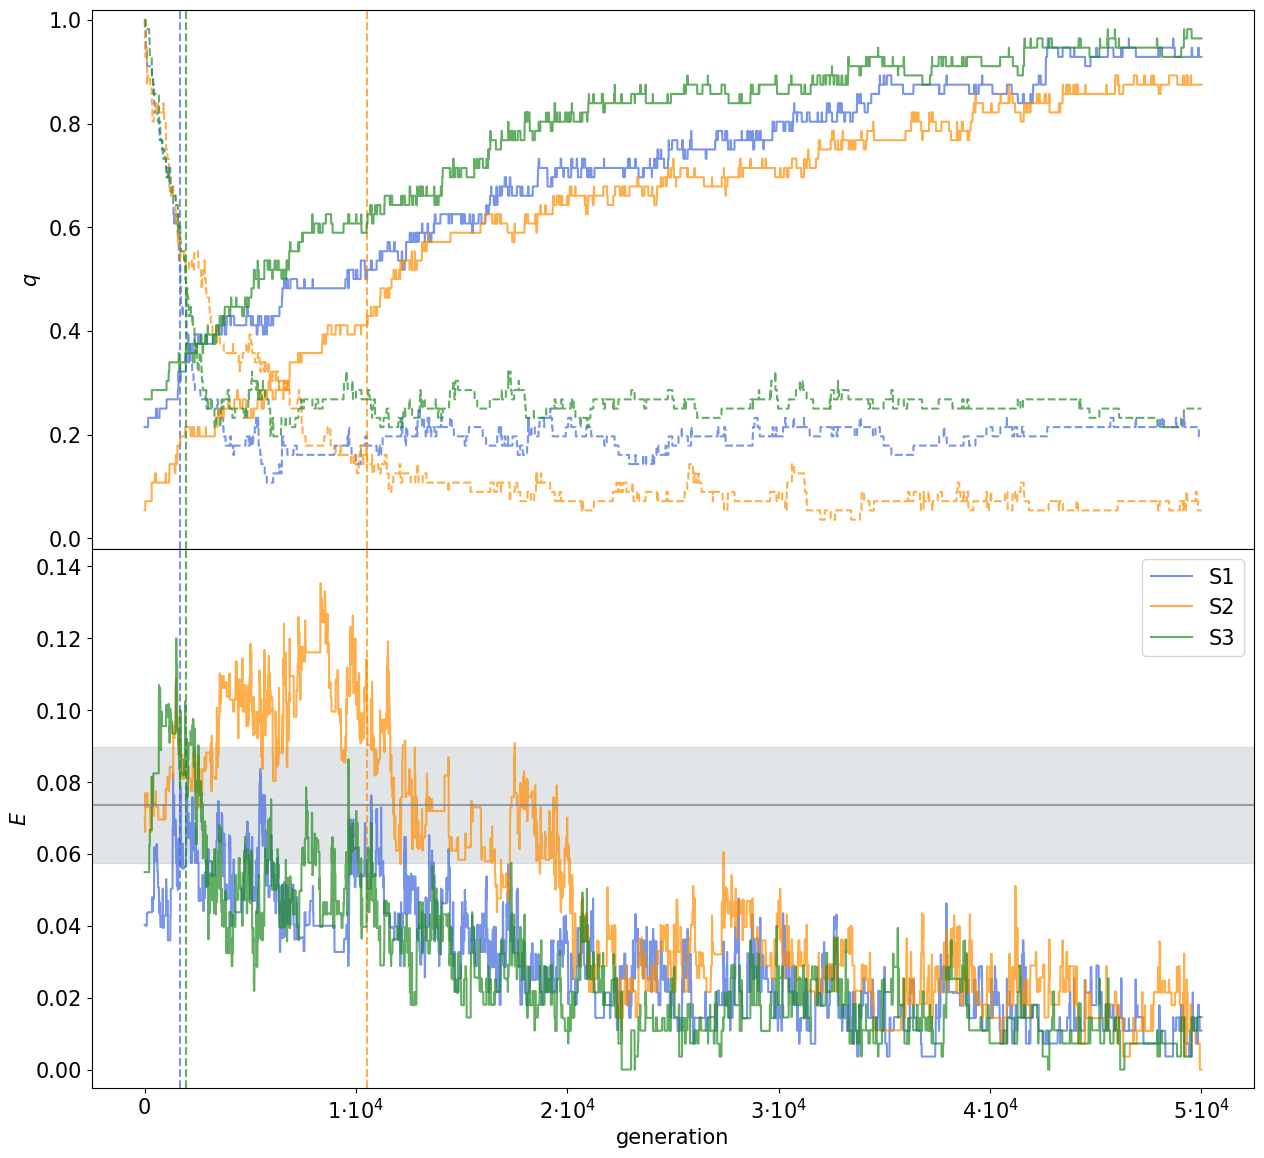

In [8]:
single_seed = True

fig, (ax1, ax2) = plt.subplots(figsize = (15, 14), nrows = 2, ncols = 1)
for d, color in zip(dirlist, colors):
    label = d.split('_')[0].split('-')[1]
    with open(f'results/{d}/README.txt', 'r') as f:
        lines = f.readlines()
    wild_type = lines[4].split(' ')[-1][:-1]
    start_mutant = lines[5].split(' ')[-1][:-1]
    print(f'{label}: {start_mutant}')
    
    seed_ds = [subd for subd in listdir(f'results/{d}') 
               if isdir(f'results/{d}/{subd}') and (not subd == '.ipynb_checkpoints')]
    
    for seed_d in seed_ds:
        actual_d = f'results/{d}/{seed_d}'
        data = load_data(actual_d)
        muts = load_muts(actual_d)
        mutants = muts[:shown_gens, 1]
        
        gens = data[:shown_gens, 0]
        energy = data[:shown_gens, 1]
        
        T, k, length = data[0, -3], data[0, -2], data[0, -1]
        if k != k_target: continue   
        seed = int(seed_d[1:])
        if not single_seed: label = f'{label}, seed {seed}'
        
        # Hamming distance
        wt_distances = calculate_Hamming_distances(mutants, wild_type, neutral_mask)
        mt_distances = calculate_Hamming_distances(mutants, start_mutant, neutral_mask)
        wt_q, mt_q = abs(1. - wt_distances/length), abs(1. - mt_distances/length)

        ax1.set_ylabel(r'$q$')
        ax1.plot(gens, wt_q, color = color, alpha = 0.7)
        ax1.plot(gens, mt_q, color = color, alpha = 0.7, linestyle = '--')
        
        # Energy
        ax2.set_ylabel(r'$E$')
        ax2.plot(gens, energy, color = color, alpha = 0.7, label = label)
        
        # Change of combination
        masked_distances = calculate_Hamming_distances(mutants, wild_type, mask)
        int_distances = masked_distances.astype(int)
        change_idx = gens[int_distances == int_distances.max()][-1]
        ax1.axvline(change_idx, color = color, alpha = 0.7, linestyle = '--')
        ax2.axvline(change_idx, color = color, alpha = 0.7, linestyle = '--')
        
        if single_seed: break

ax = ax2
ax.axhline(mean, color = 'slategrey', linewidth = 1.5, alpha = 0.7)
ax.axhspan(mean - std, mean + std, color = 'slategrey', alpha = 0.2)
ax.set_ylim([-0.005, 0.145])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('generation')
ax.legend(loc = 'upper right')

ax = ax1
ax.plot([0., 1.], [2., 2.], color = 'grey')
ax.plot([0., 1.], [2., 2.], color = 'grey', linestyle = '--')
ax.set_ylim([-0.02, 1.02])
    
plt.subplots_adjust(hspace = 0.)
plt.savefig(f'plots/ratchet.png', bbox_inches='tight');

S1: PTYRMEVMSTHFEAVVGIEAPNYPAALHGFVLFCHCLGVLAQFTYCATHNFFKVWQ
S2: HWYRFVHHGPNHECMGVARVPHVHWLMNAVEKATKAANIKCKYRWSARHRTLWCYT
S3: HEYSCMLISPLRTATQVFEATNRAMAHWFFEDMALWLGYIKKWTYNERFHMYTVTF


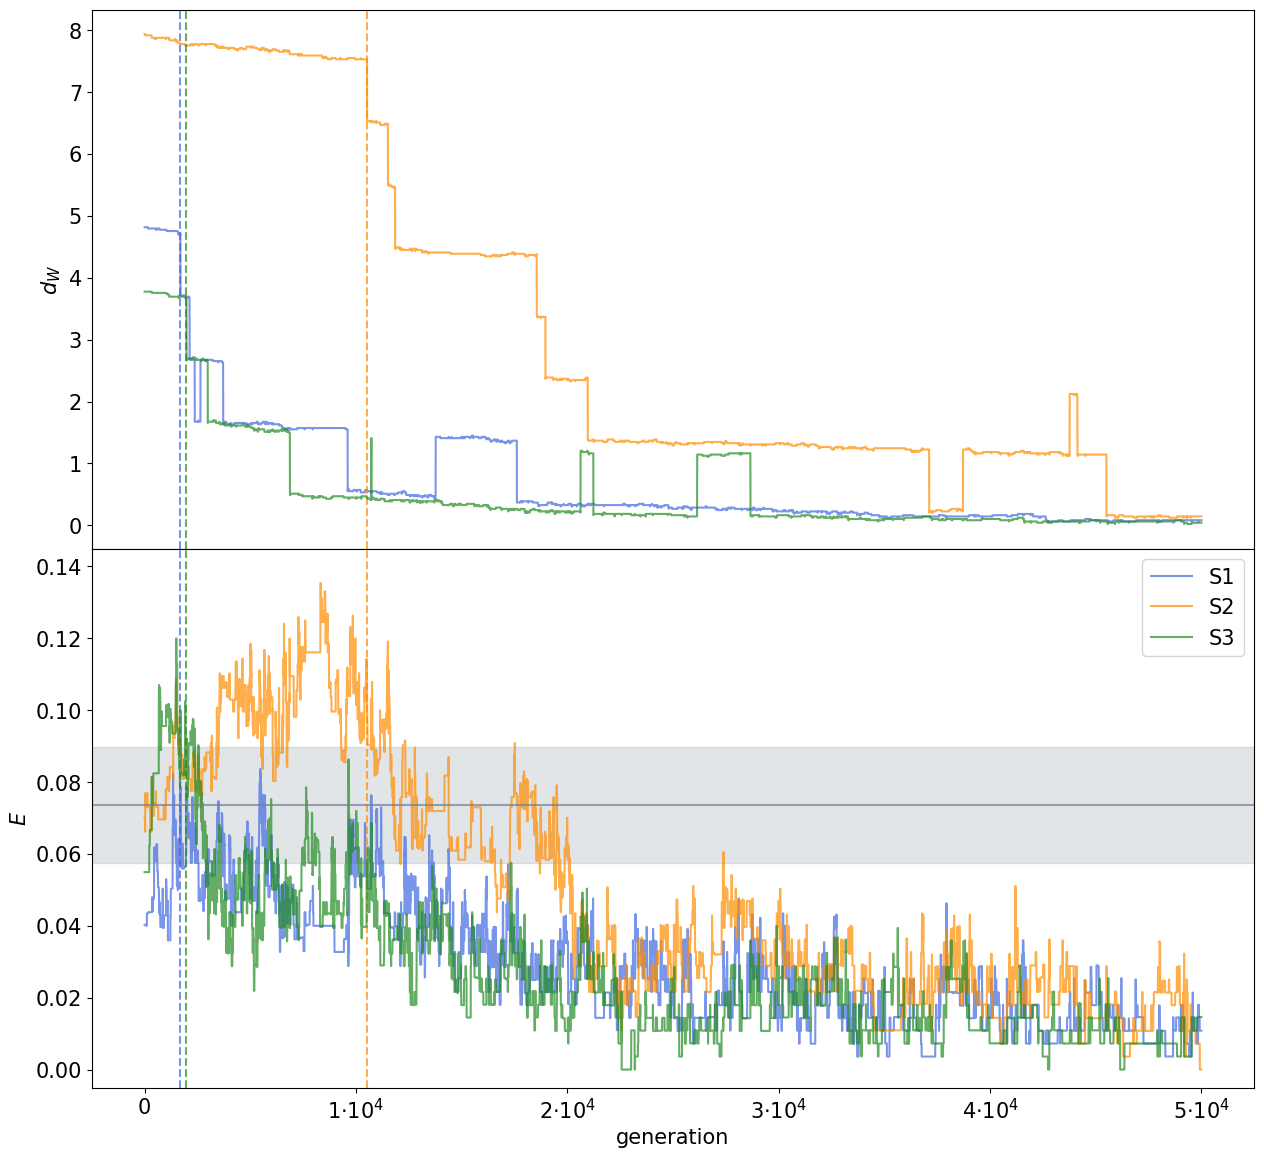

In [9]:
single_seed = True

fig, (ax1, ax2) = plt.subplots(figsize = (15, 14), nrows = 2, ncols = 1)
for d, color in zip(dirlist, colors):
    label = d.split('_')[0].split('-')[1]
    with open(f'results/{d}/README.txt', 'r') as f:
        lines = f.readlines()
    wild_type = lines[4].split(' ')[-1][:-1]
    start_mutant = lines[5].split(' ')[-1][:-1]
    print(f'{label}: {start_mutant}')
    
    seed_ds = [subd for subd in listdir(f'results/{d}') 
               if isdir(f'results/{d}/{subd}') and (not subd == '.ipynb_checkpoints')]
    
    for seed_d in seed_ds:
        actual_d = f'results/{d}/{seed_d}'
        data = load_data(actual_d)
        muts = load_muts(actual_d)
        mutants = muts[:shown_gens, 1]
        
        gens = data[:shown_gens, 0]
        energy = data[:shown_gens, 1]
        
        T, k, length = data[0, -3], data[0, -2], data[0, -1]
        if k != k_target: continue   
        seed = int(seed_d[1:])
        if not single_seed: label = f'{label}, seed {seed}'
        
        # Hamming distance
        wt_distances = calculate_Hamming_distances(mutants, wild_type, mask)

        ax1.set_ylabel(r'$d_{W}$')
        ax1.plot(gens, wt_distances, color = color, alpha = 0.7, label = start_mutant)
        
        # Energy
        ax2.set_ylabel(r'$E$')
        ax2.plot(gens, energy, color = color, alpha = 0.7, label = label)
        
        # Change of combination
        masked_distances = wt_distances.astype(int)
        change_idx = gens[masked_distances == masked_distances.max()][-1]
        ax1.axvline(change_idx, color = color, alpha = 0.7, linestyle = '--')
        ax2.axvline(change_idx, color = color, alpha = 0.7, linestyle = '--')
        
        if single_seed: break

ax = ax2
ax.axhline(mean, color = 'slategrey', linewidth = 1.5, alpha = 0.7)
ax.axhspan(mean - std, mean + std, color = 'slategrey', alpha = 0.2)
ax.set_ylim([-0.005, 0.145])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('generation')
ax.legend(loc = 'upper right')
    
plt.subplots_adjust(hspace = 0.);
plt.savefig(f'plots/supp_mat/ratchet_weighted.png', bbox_inches='tight');

S1: PTYRMEVMSTHFEAVVGIEAPNYPAALHGFVLFCHCLGVLAQFTYCATHNFFKVWQ
S2: HWYRFVHHGPNHECMGVARVPHVHWLMNAVEKATKAANIKCKYRWSARHRTLWCYT
S3: HEYSCMLISPLRTATQVFEATNRAMAHWFFEDMALWLGYIKKWTYNERFHMYTVTF


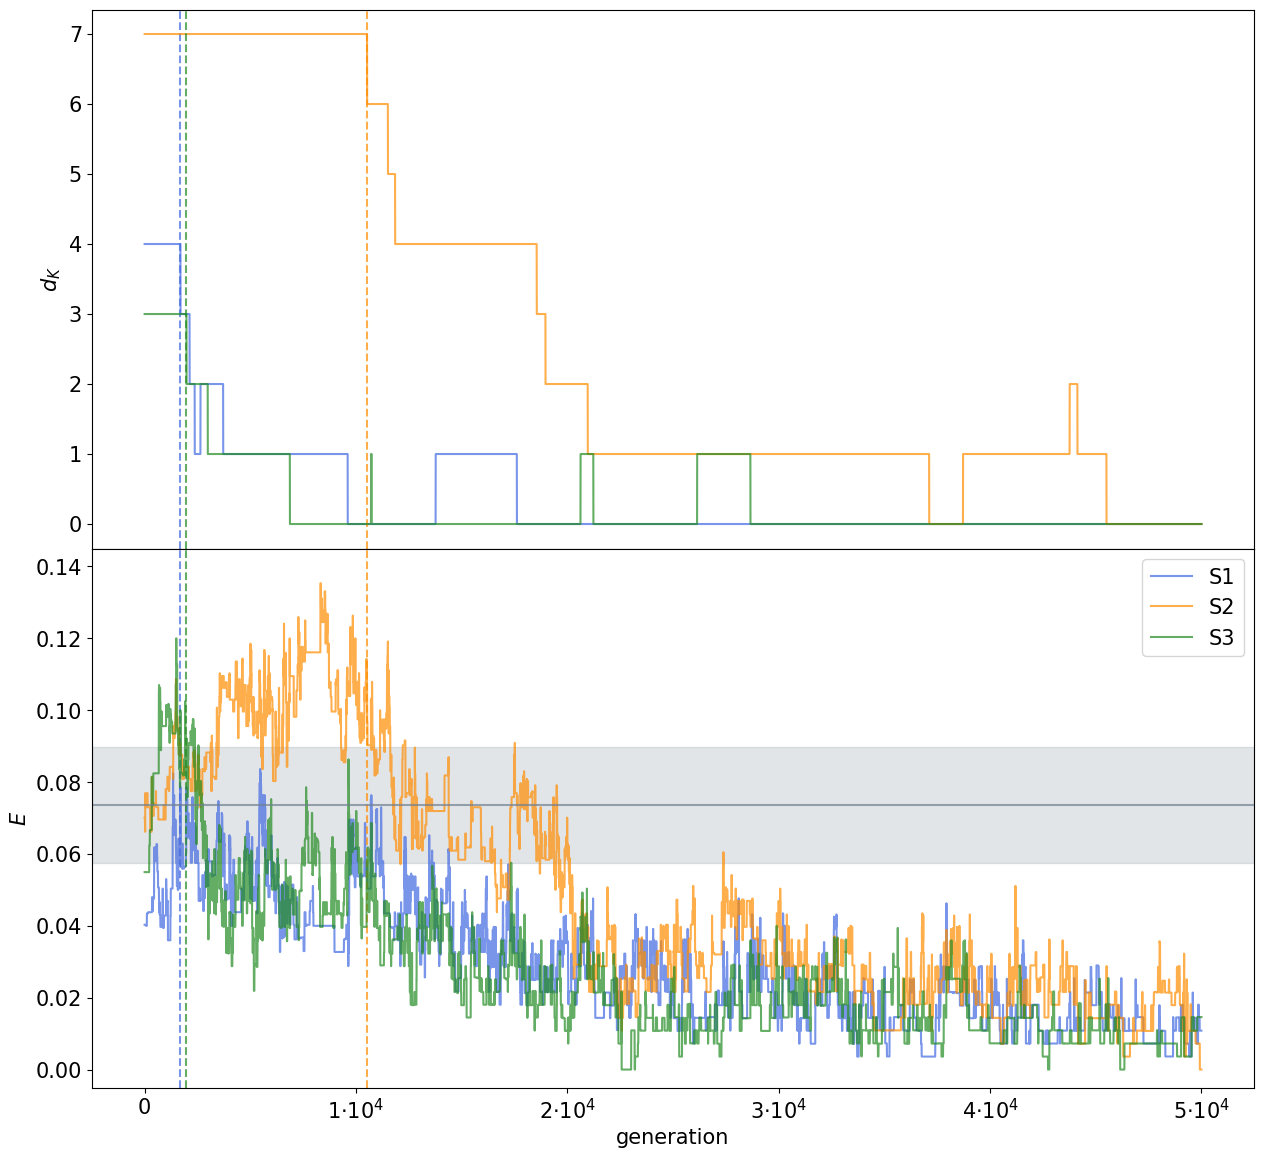

In [10]:
single_seed = True
plt.rcParams.update({'font.size': 15})


fig, (ax1, ax2) = plt.subplots(figsize = (15, 14), nrows = 2, ncols = 1)
for d, color in zip(dirlist, colors):
    label = d.split('_')[0].split('-')[1]
    with open(f'results/{d}/README.txt', 'r') as f:
        lines = f.readlines()
    wild_type = lines[4].split(' ')[-1][:-1]
    start_mutant = lines[5].split(' ')[-1][:-1]
    print(f'{label}: {start_mutant}')
    
    seed_ds = [subd for subd in listdir(f'results/{d}') 
               if isdir(f'results/{d}/{subd}') and (not subd == '.ipynb_checkpoints')]

    Ksites_wild_type = ''.join(np.array(list(wild_type))[mask])
    for seed_d in seed_ds:
        actual_d = f'results/{d}/{seed_d}'
        data = load_data(actual_d)
        muts = load_muts(actual_d)
        mutants = muts[:shown_gens, 1]
        
        gens = data[:shown_gens, 0]
        energy = data[:shown_gens, 1]
        
        T, k, length = data[0, -3], data[0, -2], data[0, -1]
        if k != k_target: continue   
        seed = int(seed_d[1:])
        if not single_seed: label = f'{label}, seed {seed}'
        
        # Hamming distance
        Ksites_mutants = np.array([''.join(np.array(list(mutant))[mask]) for mutant in mutants])
        wt_distances = calculate_Hamming_distances(Ksites_mutants, Ksites_wild_type, onlyK_mask)

        ax1.set_ylabel(r'$d_{K}$')
        ax1.plot(gens, wt_distances, color = color, alpha = 0.7, label = start_mutant)
        
        # Energy
        ax2.set_ylabel(r'$E$')
        ax2.plot(gens, energy, color = color, alpha = 0.7, label = label)
        
        # Change of combination
        masked_distances = wt_distances.astype(int)
        change_idx = gens[masked_distances == masked_distances.max()][-1]
        ax1.axvline(change_idx, color = color, alpha = 0.7, linestyle = '--')
        ax2.axvline(change_idx, color = color, alpha = 0.7, linestyle = '--')
        
        if single_seed: break

ax = ax2
ax.axhline(mean, color = 'slategrey', linewidth = 1.5, alpha = 0.7)
ax.axhspan(mean - std, mean + std, color = 'slategrey', alpha = 0.2)
ax.set_ylim([-0.005, 0.145])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('generation')
ax.legend(loc = 'upper right')
    
plt.subplots_adjust(hspace = 0.);
plt.savefig(f'plots/supp_mat/ratchet_onlyK.png', bbox_inches='tight');

S1: PTYRMEVMSTHFEAVVGIEAPNYPAALHGFVLFCHCLGVLAQFTYCATHNFFKVWQ
S2: HWYRFVHHGPNHECMGVARVPHVHWLMNAVEKATKAANIKCKYRWSARHRTLWCYT
S3: HEYSCMLISPLRTATQVFEATNRAMAHWFFEDMALWLGYIKKWTYNERFHMYTVTF


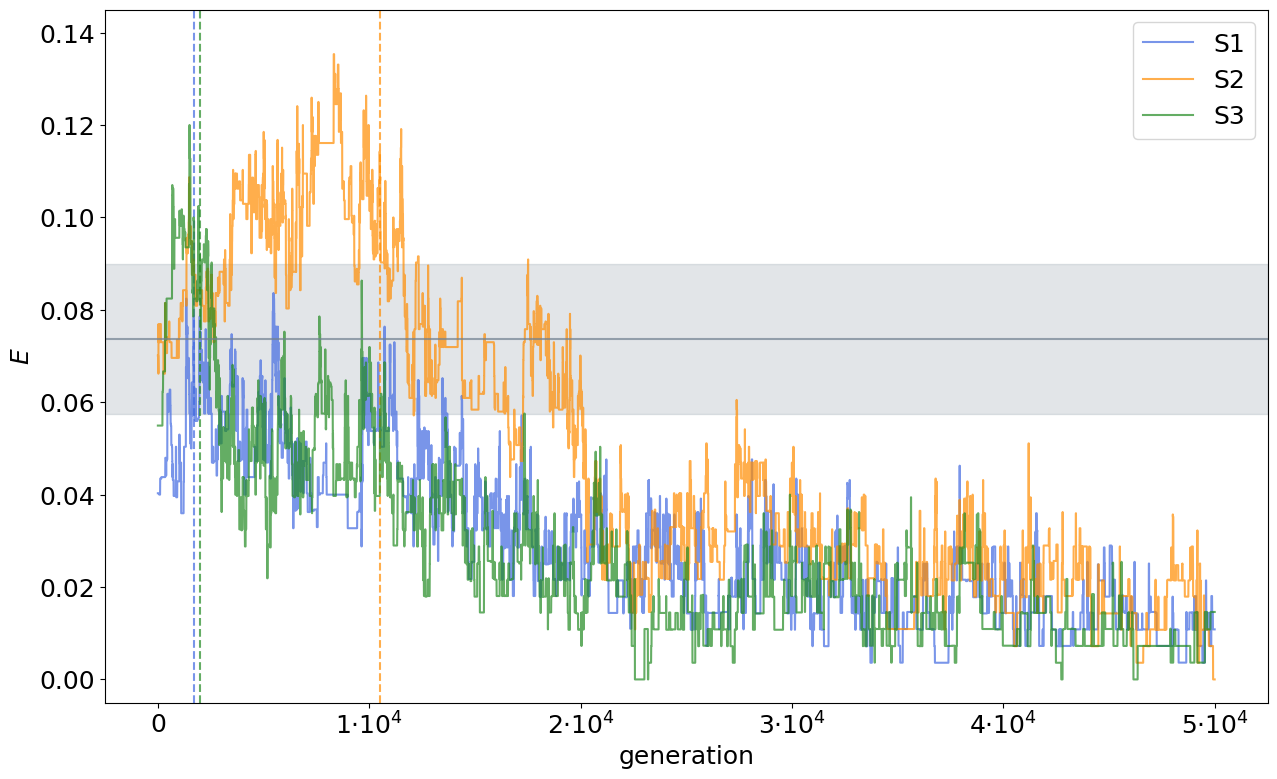

In [11]:
single_seed = True
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)
for d, color in zip(dirlist, colors):
    label = d.split('_')[0].split('-')[1]
    with open(f'results/{d}/README.txt', 'r') as f:
        lines = f.readlines()
    wild_type = lines[4].split(' ')[-1][:-1]
    start_mutant = lines[5].split(' ')[-1][:-1]
    print(f'{label}: {start_mutant}')
    
    seed_ds = [subd for subd in listdir(f'results/{d}') 
               if isdir(f'results/{d}/{subd}') and (not subd == '.ipynb_checkpoints')]

    Ksites_wild_type = ''.join(np.array(list(wild_type))[mask])
    for seed_d in seed_ds:
        actual_d = f'results/{d}/{seed_d}'
        data = load_data(actual_d)
        muts = load_muts(actual_d)
        mutants = muts[:shown_gens, 1]
        
        gens = data[:shown_gens, 0]
        energy = data[:shown_gens, 1]
        
        T, k, length = data[0, -3], data[0, -2], data[0, -1]
        if k != k_target: continue   
        seed = int(seed_d[1:])
        if not single_seed: label = f'{label}, seed {seed}'
        
        # Hamming distance
        Ksites_mutants = np.array([''.join(np.array(list(mutant))[mask]) for mutant in mutants])
        wt_distances = calculate_Hamming_distances(Ksites_mutants, Ksites_wild_type, onlyK_mask)

        # Energy
        ax.set_ylabel(r'$E$')
        ax.plot(gens, energy, color = color, alpha = 0.7, label = label)
        
        # Change of combination
        masked_distances = wt_distances.astype(int)
        change_idx = gens[masked_distances == masked_distances.max()][-1]
        ax.axvline(change_idx, color = color, alpha = 0.7, linestyle = '--')
        
        if single_seed: break

ax.axhline(mean, color = 'slategrey', linewidth = 1.5, alpha = 0.7)
ax.axhspan(mean - std, mean + std, color = 'slategrey', alpha = 0.2)
ax.set_ylim([-0.005, 0.145])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('generation')
ax.legend(loc = 'upper right')
    
plt.savefig(f'plots/supp_mat/E_ratchet.png', bbox_inches='tight');